In [1]:
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
from torch.utils.data import random_split, DataLoader
import itertools

In [2]:
class RandomRotateMNIST(torchvision.datasets.MNIST):
    def __init__(self, root: str):
        super().__init__(root, download=True)
        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])

    def __getitem__(self, item):
        image, label = super().__getitem__(item)
        rotate = torch.rand(1) > 0.5
        if rotate:
            image = image.rotate(90)
        # rotate = torch.randint(0, 3, [1]).item()
        # rotate = 350
        # rotate = 0
        # image = image.rotate(rotate * 90)

        image = self.transforms(image)

        return image, label, rotate


Input size torch.Size([1, 28, 28])


([3, 4, 3, 1, 3, 4, 1, 9],
 [tensor([True]),
  tensor([False]),
  tensor([True]),
  tensor([False]),
  tensor([False]),
  tensor([False]),
  tensor([True]),
  tensor([True])])

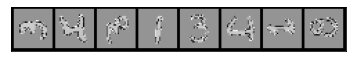

In [3]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.ToPILImage()(img)
        axs[0, i].imshow(np.asarray (img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


data_root = os.path.join("..", "data")
mnist_dataset = RandomRotateMNIST(data_root)
data = [mnist_dataset[i] for i in [10, 20, 30, 40, 50, 60, 70, 80]]
images = [d[0] for d in data]
labels = [d[1] for d in data]
rotate = [d[2] for d in data]
input_size = images[0].shape
print("Input size", input_size)
grid = torchvision.utils.make_grid(images)
show(grid)
labels, rotate

In [4]:
output_width = 100
digit_classes = 10

class ConceptEmbedder(nn.Module):
    def __init__(self, input_dim=input_size,
                 n_classes=digit_classes, output_dim=output_width):
        super(ConceptEmbedder, self).__init__()
        self.flatten = nn.Flatten()
        input_dim = np.prod(input_dim)
        self.fc1 = nn.Linear(input_dim, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, n_classes * output_dim)
        self.unflatten = nn.Unflatten(1, (n_classes, output_dim))

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.unflatten(x)
        x = F.sigmoid(x)
        return x

net = ConceptEmbedder()
out = net(torch.stack(images))
out.size()

C:\Users\gabri\Anaconda3\envs\fsc\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([8, 10, 100])

In [5]:
class MLP(nn.Module):
    def __init__(self, n_classes=1, input_width=(digit_classes,output_width)):
        super(MLP, self).__init__()
        input_dim = np.prod(input_width)
        self.linear1 = nn.Linear(input_dim, output_width)
        self.linear2 = nn.Linear(output_width, 10)
        self.linear3 = nn.Linear(10, n_classes)
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        # return torch.sigmoid(x)
        return x

net2 = MLP()
out2 = net2(out)
out2

tensor([[0.3517],
        [0.3610],
        [0.3583],
        [0.3575],
        [0.3552],
        [0.3590],
        [0.3594],
        [0.3540]], grad_fn=<AddmmBackward>)

In [41]:
def vectorial_loss(f:torch.Tensor, y:np.ndarray):
    norm_f = torch.norm(f, dim=2)
    l = torch.nn.CrossEntropyLoss()(norm_f, y)
    return l

mlp_loss = nn.MSELoss()
def train(model, model2, device, train_loader, optimizer, epoch,
          model_loss=vectorial_loss):
    model.train()
    for batch_idx, (data, target, rotate_target) in enumerate(train_loader):
        data = data.to(device) 
        target = target.to(device)
        rotate_target = rotate_target.to(device).to(torch.float)
        
        optimizer.zero_grad()
        output = model(data)
        output2 = model2(output)

        loss1 = model_loss(output, target)
        loss2 = mlp_loss(output2, rotate_target)
        loss2 = torch.sqrt(loss2)

        loss = loss1 + 0.5 * loss2 if epoch > epochs//5 else loss1
        loss.backward()
        optimizer.step()
        
        if (batch_idx) % 10 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]"
                  f"({100. * batch_idx / (len(train_loader)):.0f}%)]"
                  f"\tLoss: {loss.item():.6f} {loss1.item():.6f} {loss2.item():.6f} ")


def test(model, model2, device, test_loader, model_loss=vectorial_loss):
    model.eval()
    test_loss, correct = 0, 0
    test_loss2, correct2 = 0, 0
    with torch.no_grad():
        for data, target, rotate_target in test_loader:
            data = data.to(device)
            target = target.to(device)
            rotate_target = rotate_target.to(device).to(torch.float)

            output = model(data)
            output2 = model2(output)

            test_loss += model_loss(output, target)  # sum up batch loss
            output = output.norm(dim=2)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss2 += mlp_loss(output2, rotate_target) # sum up batch loss
            # test_loss2 = mlp_loss(output2, rotate_target)
            # test_loss2 = torch.sqrt(test_loss2)
            pred2 = output2 > 0.5  # get the index of the max log-probability
            correct2 += pred2.eq(rotate_target.view_as(pred2)).sum().item()

    test_loss /= len(test_loader)
    test_loss2 /= len(test_loader)

    print('\nTest set: Average loss: {:.4f} {:.4f}, Accuracy: ({:.0f}%) ({:.0f}%) \n'.format(
        test_loss, test_loss2,
        100. * correct / len(test_loader.dataset),
        100. * correct2 / len(test_loader.dataset)))

In [40]:
train_size = int(0.5 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size
train_set, test_set = random_split(mnist_dataset,
                                   [train_size, test_size])

epochs = 100
batch_size= 1024
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size)

device = torch.device("cuda:0") if torch.cuda.is_available() \
    else torch.device("cpu")
print("Device", device)

Device cpu


In [8]:
# net = ConceptEmbedder().to(device)
# net2 = MLP().to(device)
#
# optimizer = torch.optim.AdamW(itertools.chain(net.parameters(), net2.parameters()))
#
# for epoch in range(1, epochs + 1):
#     train(net, net2, device, train_loader, optimizer, epoch)
#     test(net, net2, device, test_loader)
#     torch.save(net.state_dict(), "mnist_cnn.pt")
#     torch.save(net2.state_dict(), "mlp.pt")
#

In [9]:
# data = [mnist_dataset[i] for i in torch.randint(0, len(mnist_dataset), (8,))]
# images = [d[0] for d in data]
# labels = [d[1] for d in data]
# rot_lab = [d[2] for d in data]
# grid = torchvision.utils.make_grid(images)
# show(grid)
# out = net(torch.stack(images).to(device))
# print("Output", out.squeeze())
# print("Predicted numbers", out.norm(dim=2).argmax(dim=1))
# print("Labels", labels)
# out2 = net2(out)
# # print("Predicted rotations", ["Rotated" if o > 0.5 else "Not Rotated" for o in out2])
# print("Predicted rotations", out2.squeeze())
# print("Rotation labels", rot_lab)
#

In [33]:
class FuzzyConcepts(nn.Module):
    def __init__(self, input_dim=input_size,
                 n_classes=digit_classes):
        super(FuzzyConcepts, self).__init__()
        self.flatten = nn.Flatten()
        input_dim = np.prod(input_dim)
        self.fc1 = nn.Linear(input_dim, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x

net = FuzzyConcepts()
out = net(torch.stack(images))
out.size()


net2 = MLP(input_width=(1,digit_classes))
out2 = net2(out)
out2

In [42]:
def test(model, model2, device, test_loader, model_loss=vectorial_loss):
    model.eval()
    test_loss, correct = 0, 0
    test_loss2, correct2 = 0, 0
    with torch.no_grad():
        for data, target, rotate_target in test_loader:
            data = data.to(device)
            target = target.to(device)
            rotate_target = rotate_target.to(device).to(torch.float)

            output = model(data)
            output2 = model2(output)

            test_loss += model_loss(output, target)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss2 += mlp_loss(output2, rotate_target) # sum up batch loss
            # test_loss2 = mlp_loss(output2, rotate_target)
            # test_loss2 = torch.sqrt(test_loss2)
            pred2 = output2 > 0.5  # get the index of the max log-probability
            correct2 += pred2.eq(rotate_target.view_as(pred2)).sum().item()

    test_loss /= len(test_loader)
    test_loss2 /= len(test_loader)

    print('\nTest set: Average loss: {:.4f} {:.4f}, Accuracy: ({:.0f}%) ({:.0f}%) \n'.format(
        test_loss, test_loss2,
        100. * correct / len(test_loader.dataset),
        100. * correct2 / len(test_loader.dataset)))

net = FuzzyConcepts().to(device)
net2 = MLP(input_width=(1,digit_classes))

optimizer = torch.optim.AdamW(itertools.chain(net.parameters(), net2.parameters()))

for epoch in range(1, epochs + 1):
    train(net, net2, device, train_loader, optimizer,
          epoch, torch.nn.CrossEntropyLoss())
    test(net, net2, device, test_loader,
         torch.nn.CrossEntropyLoss())
    torch.save(net.state_dict(), "mnist_cnn.pt")
    torch.save(net2.state_dict(), "mlp.pt")


Train Epoch: 1 [0/30000](0%)]	Loss: 2.301888 2.301888 1.098146 
Train Epoch: 1 [10240/30000](33%)]	Loss: 1.956718 1.956718 1.010136 
Train Epoch: 1 [20480/30000](67%)]	Loss: 1.753410 1.753410 0.981772 

Test set: Average loss: 1.7110 1.0466, Accuracy: (76%) (50%) 

Train Epoch: 2 [0/30000](0%)]	Loss: 1.719484 1.719484 1.011275 
Train Epoch: 2 [10240/30000](33%)]	Loss: 1.677587 1.677587 1.045286 
Train Epoch: 2 [20480/30000](67%)]	Loss: 1.659177 1.659177 1.017114 

Test set: Average loss: 1.6481 1.0473, Accuracy: (81%) (50%) 

Train Epoch: 3 [0/30000](0%)]	Loss: 1.631517 1.631517 1.021284 
Train Epoch: 3 [10240/30000](33%)]	Loss: 1.634380 1.634380 1.035916 
Train Epoch: 3 [20480/30000](67%)]	Loss: 1.611085 1.611085 0.995174 

Test set: Average loss: 1.6086 1.0415, Accuracy: (85%) (50%) 

Train Epoch: 4 [0/30000](0%)]	Loss: 1.599005 1.599005 1.044858 
Train Epoch: 4 [10240/30000](33%)]	Loss: 1.601208 1.601208 1.036110 
Train Epoch: 4 [20480/30000](67%)]	Loss: 1.586302 1.586302 1.026264 


In [43]:
def steep_sigmoid(input, k=100, b=0.5):
    output = 1 / (1 + torch.exp(-k*(input-b)))
    return output

class BooleanConcepts(FuzzyConcepts):
    def forward(self, x):
        x = super().forward(x)
        x = steep_sigmoid(x)
        return x.float()

net = BooleanConcepts()
out = net(torch.stack(images))
out.size()


net2 = MLP(input_width=(1,digit_classes))
out2 = net2(out)
out2


tensor([[-0.2523],
        [-0.1694],
        [-0.1779],
        [-0.1585],
        [-0.1482],
        [-0.1254],
        [-0.1511],
        [-0.1771]], grad_fn=<AddmmBackward>)

In [44]:
net = BooleanConcepts().to(device)
net2 = MLP(input_width=(1,digit_classes))

optimizer = torch.optim.AdamW(itertools.chain(net.parameters(), net2.parameters()))

for epoch in range(1, epochs + 1):
    train(net, net2, device, train_loader, optimizer,
          epoch, torch.nn.CrossEntropyLoss())
    test(net, net2, device, test_loader,
         torch.nn.CrossEntropyLoss())
    torch.save(net.state_dict(), "mnist_cnn.pt")
    torch.save(net2.state_dict(), "mlp.pt")


Train Epoch: 1 [0/30000](0%)]	Loss: 2.397697 2.397697 0.876359 
Train Epoch: 1 [10240/30000](33%)]	Loss: 1.723414 1.723414 0.748506 
Train Epoch: 1 [20480/30000](67%)]	Loss: 1.637810 1.637810 0.737359 

Test set: Average loss: 1.5999 0.5588, Accuracy: (85%) (50%) 

Train Epoch: 2 [0/30000](0%)]	Loss: 1.584323 1.584323 0.747430 
Train Epoch: 2 [10240/30000](33%)]	Loss: 1.574102 1.574102 0.748998 
Train Epoch: 2 [20480/30000](67%)]	Loss: 1.558846 1.558846 0.743932 

Test set: Average loss: 1.5542 0.5473, Accuracy: (90%) (50%) 

Train Epoch: 3 [0/30000](0%)]	Loss: 1.545489 1.545489 0.742184 
Train Epoch: 3 [10240/30000](33%)]	Loss: 1.540559 1.540559 0.723988 
Train Epoch: 3 [20480/30000](67%)]	Loss: 1.537461 1.537461 0.747698 

Test set: Average loss: 1.5413 0.5514, Accuracy: (92%) (50%) 

Train Epoch: 4 [0/30000](0%)]	Loss: 1.532568 1.532568 0.742775 
Train Epoch: 4 [10240/30000](33%)]	Loss: 1.524132 1.524132 0.717395 
Train Epoch: 4 [20480/30000](67%)]	Loss: 1.521142 1.521142 0.745510 


KeyboardInterrupt: 